In [58]:
!pip install implicit
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, coo_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import time
import warnings
import os
import kagglehub
import implicit
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import time
import math
from collections import defaultdict

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

In [59]:
path = kagglehub.dataset_download("sherinclaudia/movielens")
print("Path to dataset files:", path)

print(f"Fichiers dans le répertoire: {os.listdir(path)}")
print(f"Chemin des données: {path}")

Path to dataset files: /kaggle/input/movielens
Fichiers dans le répertoire: ['users.dat', 'ratings.dat', 'movies.dat']
Chemin des données: /kaggle/input/movielens


In [60]:
import pandas as pd

movies = pd.read_csv(os.path.join(path, 'movies.dat'), sep="::", engine="python", names=["MovieID", "Title", "Genres"], encoding="latin1")
ratings = pd.read_csv(os.path.join(path, 'ratings.dat'), sep="::", engine="python", names=["UserID", "MovieID", "Rating", "Timestamp"], encoding="latin1", usecols=["UserID", "MovieID", "Rating"])
users = pd.read_csv(os.path.join(path, 'users.dat'), sep="::", engine="python", names=["UserID", "Gender", "Age", "Occupation", "Zip-code"], encoding="latin1")


In [61]:
# movies.head()
ratings.head()
# users.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [62]:
# Dimensions utilisateur × item
num_users = ratings['UserID'].nunique()
num_items = ratings['MovieID'].nunique()
num_ratings = len(ratings)

# Densité et sparsité
density = num_ratings / (num_users * num_items)
sparsity = 1 - density

print(f"Nombre d'utilisateurs : {num_users}")
print(f"Nombre de films : {num_items}")
print(f"Nombre de notes : {num_ratings}")
print(f"Densité : {density*100:.4f}%")
print(f"Sparsité : {sparsity*100:.4f}%")

Nombre d'utilisateurs : 6040
Nombre de films : 3706
Nombre de notes : 1000209
Densité : 4.4684%
Sparsité : 95.5316%


In [63]:
user_id = 1
user_ratings = ratings[ratings['UserID'] == user_id]
user_ratings = user_ratings.merge(movies[['MovieID', 'Title']], on='MovieID')

user_ratings = user_ratings.sort_values(by='Rating', ascending=False)
print(f"L'utilisateur {user_id} a noté {len(user_ratings)} films :")
display(user_ratings.head(10))  # top 10

L'utilisateur 1 a noté 53 films :


,UserID,MovieID,Rating,Title
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975)
4,1,2355,5,"Bug's Life, A (1998)"
10,1,595,5,Beauty and the Beast (1991)
7,1,2804,5,"Christmas Story, A (1983)"
6,1,1287,5,Ben-Hur (1959)
18,1,3105,5,Awakenings (1990)
14,1,1035,5,"Sound of Music, The (1965)"
40,1,1,5,Toy Story (1995)
41,1,1961,5,Rain Man (1988)
36,1,1836,5,"Last Days of Disco, The (1998)"


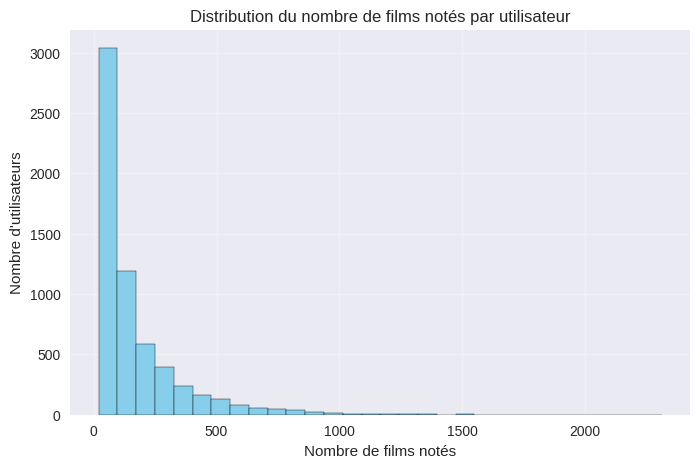

In [64]:
user_activity = ratings.groupby('UserID')['MovieID'].count()

plt.figure(figsize=(8,5))
plt.hist(user_activity, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Nombre de films notés")
plt.ylabel("Nombre d'utilisateurs")
plt.title("Distribution du nombre de films notés par utilisateur")
plt.grid(alpha=0.3)
plt.show()

In [65]:
def create_rating_matrix(ratings, normalize=True):
    """Crée une matrice sparse des ratings avec mapping d'IDs et option de normalisation"""
    
    # 🔹 Étape 1 : Normalisation des ratings (facultative)
    if normalize:
        min_rating = ratings['Rating'].min()
        max_rating = ratings['Rating'].max()
        ratings['Rating_norm'] = (ratings['Rating'] - min_rating) / (max_rating - min_rating)
        ratings_val = ratings['Rating_norm'].values
        print(f"✅ Ratings normalisés entre 0 et 1 (min={min_rating}, max={max_rating})")
    else:
        ratings_val = ratings['Rating'].values
    
    # 🔹 Étape 2 : Mapping des IDs vers des index consécutifs
    user_map = {u: i for i, u in enumerate(ratings['UserID'].unique())}
    item_map = {m: i for i, m in enumerate(ratings['MovieID'].unique())}
    
    user_indices = ratings['UserID'].map(user_map)
    item_indices = ratings['MovieID'].map(item_map)

    # 🔹 Étape 3 : Construction de la matrice sparse
    n_users = len(user_map)
    n_items = len(item_map)
    
    rating_matrix = csr_matrix((ratings_val, (user_indices, item_indices)), shape=(n_users, n_items))
    
    return rating_matrix, user_map, item_map, n_users, n_items, (min_rating, max_rating)


# --- utilisation ---
rating_matrix, user_map, item_map, n_users, n_items, scale = create_rating_matrix(ratings, normalize=True)

print(f"Dimensions de la matrice: {rating_matrix.shape[0]} utilisateurs × {rating_matrix.shape[1]} films")
print(f"Nombre total de ratings: {rating_matrix.nnz}")
print("Matrice créée avec succès !")

✅ Ratings normalisés entre 0 et 1 (min=1, max=5)
Dimensions de la matrice: 6040 utilisateurs × 3706 films
Nombre total de ratings: 1000209
Matrice créée avec succès !


In [66]:
print(rating_matrix[:10, :20].toarray())

[[1.   0.5  0.5  0.75 1.   0.5  1.   1.   0.75 0.75 1.   0.75 0.75 0.75
  1.   0.75 0.5  0.75 1.   0.75]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.75 0.  ]
 [0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.5  1.   0.   0.   0.   0.   0.75 0.   0.   0.   0.
  0.   0.   0.   0.   0.25 0.  ]
 [0.   0.   1.   1.   0.   0.   0.   0.   0.   0.   0.75 0.   0.   0.
  1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.75 0.  ]
 [0.   0.   0.   0.75 0.75 0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.75 0.75 1.   0.5  1.   1.   1.   1.   0.75 1.   1.
 

In [67]:
def train_test_split_sparse_per_user(matrix, test_ratio=0.25, random_state=42):
    
    np.random.seed(random_state)
    matrix = matrix.tocsr()

    n_users, n_items = matrix.shape
    train_rows, train_cols, train_data = [], [], []
    test_rows, test_cols, test_data = [], [], []

    for user in range(n_users):
        start, end = matrix.indptr[user], matrix.indptr[user + 1]
        user_items = matrix.indices[start:end]
        user_ratings = matrix.data[start:end]

        if len(user_items) == 0:
            continue

        # Si l'utilisateur a très peu de notes, tout en train
        if len(user_items) <= 2:
            train_rows.extend([user] * len(user_items))
            train_cols.extend(user_items)
            train_data.extend(user_ratings)
            continue

        # Sélection aléatoire d'un sous-ensemble pour test
        n_test = max(1, int(len(user_items) * test_ratio))
        indices = np.arange(len(user_items))
        np.random.shuffle(indices)

        test_idx = indices[:n_test]
        train_idx = indices[n_test:]

        # Train
        train_rows.extend([user] * len(train_idx))
        train_cols.extend(user_items[train_idx])
        train_data.extend(user_ratings[train_idx])

        # Test
        test_rows.extend([user] * len(test_idx))
        test_cols.extend(user_items[test_idx])
        test_data.extend(user_ratings[test_idx])

    train_matrix = csr_matrix((train_data, (train_rows, train_cols)), shape=(n_users, n_items))
    test_matrix = csr_matrix((test_data, (test_rows, test_cols)), shape=(n_users, n_items))

    print(f"✅ Split terminé : {train_matrix.nnz:,} train / {test_matrix.nnz:,} test ratings")
    print(f"  -> Train density: {train_matrix.nnz / (n_users * n_items):.6f}")
    print(f"  -> Test density : {test_matrix.nnz / (n_users * n_items):.6f}")
    
    return train_matrix, test_matrix

In [68]:
train_matrix, test_matrix = train_test_split_sparse_per_user(rating_matrix, test_ratio=0.25)
print(f"Train nnz: {train_matrix.nnz}, Test nnz: {test_matrix.nnz}")

print(f"Train set: {train_matrix.nnz} ratings")
print(f"Test set: {test_matrix.nnz} ratings")
print(f"Ratio train/test: {train_matrix.nnz/(train_matrix.nnz + test_matrix.nnz):.2%}")

# ------------------------------
# Préparer matrices pour ALS
# ------------------------------
train_matrix_implicit = train_matrix.astype(np.float32)
test_matrix_implicit = test_matrix.astype(np.float32)

print(f"\n📊 Matrices prêtes pour ALS:")
print(f"   Train matrix: CSR (float32) pour implicit")
print(f"   Test matrix: CSR (float32) pour implicit")
print(f"   Dimensions: {n_users} users × {n_items} items")

✅ Split terminé : 752,365 train / 247,844 test ratings
  -> Train density: 0.033611
  -> Test density : 0.011072
Train nnz: 752365, Test nnz: 247844
Train set: 752365 ratings
Test set: 247844 ratings
Ratio train/test: 75.22%

📊 Matrices prêtes pour ALS:
   Train matrix: CSR (float32) pour implicit
   Test matrix: CSR (float32) pour implicit
   Dimensions: 6040 users × 3706 items


In [69]:
class ALSRecommender:
    def __init__(self, n_factors=15, lambda_reg=0.1, n_iterations=15, alpha=10, 
                 early_stopping_rounds=3, tolerance=1e-4, verbose=True):
        self.n_factors = n_factors
        self.lambda_reg = lambda_reg
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.early_stopping_rounds = early_stopping_rounds
        self.tolerance = tolerance
        self.verbose = verbose
        self.user_factors = None
        self.item_factors = None
        self.best_iteration = 0
        
    def fit(self, train_matrix, validation_matrix=None):
        """Entraîne le modèle ALS avec early stopping"""
        n_users, n_items = train_matrix.shape
        
        # Initialisation stable et positive
        self.user_factors = np.random.rand(n_users, self.n_factors) * 0.01
        self.item_factors = np.random.rand(n_items, self.n_factors) * 0.01

        I = np.eye(self.n_factors)
        lambda_I = self.lambda_reg * I
        
        train_coo = train_matrix.tocoo()
        
        self.train_rmse = []
        self.train_mae = []
        self.val_rmse = []
        self.val_mae = []
        self.best_rmse = float('inf')
        self.best_mae = float('inf')
        self.best_user_factors = None
        self.best_item_factors = None
        no_improvement_count = 0
        
        start_time = time.time()
        
        for iteration in range(self.n_iterations):
            iteration_start = time.time()

            # === Étape 1: Optimiser les utilisateurs ===
            for user_id in range(n_users):
                user_mask = (train_coo.row == user_id)
                if np.sum(user_mask) == 0:
                    continue
                    
                rated_items = train_coo.col[user_mask]
                ratings = train_coo.data[user_mask]
                
                M_u = self.item_factors[rated_items, :]
                r_u = ratings
                
                M_u_T = M_u.T
                A = M_u_T.dot(M_u) + lambda_I
                b = M_u_T.dot(r_u)
                self.user_factors[user_id, :] = np.linalg.solve(A, b)
            
            # === Étape 2: Optimiser les items ===
            for item_id in range(n_items):
                item_mask = (train_coo.col == item_id)
                if np.sum(item_mask) == 0:
                    continue
                    
                rated_users = train_coo.row[item_mask]
                ratings = train_coo.data[item_mask]
                
                U_i = self.user_factors[rated_users, :]
                r_i = ratings
                
                U_i_T = U_i.T
                A = U_i_T.dot(U_i) + lambda_I
                b = U_i_T.dot(r_i)
                self.item_factors[item_id, :] = np.linalg.solve(A, b)
            
            # Calcul des métriques
            train_rmse = self.calculate_rmse(train_matrix)
            train_mae = self.calculate_mae(train_matrix)
            self.train_rmse.append(train_rmse)
            self.train_mae.append(train_mae)
            
            if validation_matrix is not None:
                val_rmse = self.calculate_rmse(validation_matrix)
                val_mae = self.calculate_mae(validation_matrix)
                self.val_rmse.append(val_rmse)
                self.val_mae.append(val_mae)
                current_rmse = val_rmse
                current_mae = val_mae
            else:
                current_rmse = train_rmse
                current_mae = train_mae
            
            iteration_time = time.time() - iteration_start
            
            # Early stopping logic (basé sur RMSE)
            improvement = self.best_rmse - current_rmse
            if improvement > self.tolerance:
                self.best_rmse = current_rmse
                self.best_mae = current_mae
                self.best_user_factors = self.user_factors.copy()
                self.best_item_factors = self.item_factors.copy()
                self.best_iteration = iteration
                no_improvement_count = 0
                
                if self.verbose:
                    print(f"🌟 Meilleure performance à l'itération {iteration+1}: RMSE = {current_rmse:.4f}, MAE = {current_mae:.4f}")
            else:
                no_improvement_count += 1
                if self.verbose:
                    print(f"⏳ Pas d'amélioration depuis {no_improvement_count} itération(s)")
            
            # Affichage des résultats de l'itération
            if self.verbose:
                val_info = f" - RMSE Val: {val_rmse:.4f}, MAE Val: {val_mae:.4f}" if validation_matrix is not None else ""
                print(f"Itération {iteration+1}/{self.n_iterations} - RMSE Train: {train_rmse:.4f}, MAE Train: {train_mae:.4f}{val_info} - Temps: {iteration_time:.2f}s")
            
            # Vérification de l'early stopping
            if no_improvement_count >= self.early_stopping_rounds:
                if self.verbose:
                    print(f"🚀 Early stopping déclenché à l'itération {iteration+1}")
                    print(f"🎯 Meilleure itération: {self.best_iteration + 1} avec RMSE: {self.best_rmse:.4f}, MAE: {self.best_mae:.4f}")
                break
        
        # Restauration des meilleurs paramètres
        if self.best_user_factors is not None:
            self.user_factors = self.best_user_factors
            self.item_factors = self.best_item_factors
        
        total_time = time.time() - start_time
        if self.verbose:
            print(f"✅ Entraînement terminé en {total_time:.2f}s")
            print(f"📊 Meilleure performance: RMSE = {self.best_rmse:.4f}, MAE = {self.best_mae:.4f} à l'itération {self.best_iteration + 1}")
    
    def predict(self, user_id, item_id):
        """Prédit la note avec clipping"""
        if self.user_factors is None or self.item_factors is None:
            raise ValueError("Le modèle n'est pas encore entraîné. Appelez fit() d'abord.")
        
        prediction = self.user_factors[user_id, :].dot(self.item_factors[item_id, :].T)
        return np.clip(prediction, 0.0, 1.0)
    
    def calculate_rmse(self, matrix):
        """Calcule le RMSE de manière optimisée"""
        predictions = []
        actuals = []
        
        matrix_coo = matrix.tocoo()
        
        # Calcul batch pour plus de performance
        user_ids = matrix_coo.row
        item_ids = matrix_coo.col
        ratings = matrix_coo.data
        
        # Prédictions vectorisées
        preds = np.sum(self.user_factors[user_ids] * self.item_factors[item_ids], axis=1)
        preds = np.clip(preds, 0.0, 1.0)
        
        return np.sqrt(np.mean((ratings - preds) ** 2))
    
    def calculate_mae(self, matrix):
        """Calcule le MAE (Mean Absolute Error)"""
        matrix_coo = matrix.tocoo()
        
        # Calcul batch pour plus de performance
        user_ids = matrix_coo.row
        item_ids = matrix_coo.col
        ratings = matrix_coo.data
        
        # Prédictions vectorisées
        preds = np.sum(self.user_factors[user_ids] * self.item_factors[item_ids], axis=1)
        preds = np.clip(preds, 0.0, 1.0)
        
        return np.mean(np.abs(ratings - preds))
    
    def calculate_both_metrics(self, matrix):
        """Calcule RMSE et MAE en une seule passe (plus efficace)"""
        matrix_coo = matrix.tocoo()
        
        user_ids = matrix_coo.row
        item_ids = matrix_coo.col
        ratings = matrix_coo.data
        
        # Prédictions vectorisées
        preds = np.sum(self.user_factors[user_ids] * self.item_factors[item_ids], axis=1)
        preds = np.clip(preds, 0.0, 1.0)
        
        errors = ratings - preds
        rmse = np.sqrt(np.mean(errors ** 2))
        mae = np.mean(np.abs(errors))
        
        return rmse, mae
    
    def recommend_for_user(self, user_id, n_recommendations=10, min_ratings=5, include_actual=False):
        """
        Recommandations ALS avec filtrage de popularité et possibilité d'afficher la note réelle.
        """
        if self.user_factors is None or self.item_factors is None:
            raise ValueError("Le modèle n'est pas encore entraîné. Appelez fit() d'abord.")
        
        user_ratings = train_matrix[user_id, :].toarray().flatten()
        rated_items = set(np.where(user_ratings > 0)[0])
        
        item_popularity = np.array(train_matrix.getnnz(axis=0)).flatten()
        
        predictions = []
        for item_id in range(self.item_factors.shape[0]):
            if item_id not in rated_items and item_popularity[item_id] >= min_ratings:
                pred_rating = self.predict(user_id, item_id)
                actual_rating = test_matrix[user_id, item_id] if include_actual else None
                predictions.append((item_id, pred_rating, actual_rating, item_popularity[item_id]))
        
        # Tri: note prédite (desc), puis popularité (desc)
        predictions.sort(key=lambda x: (-x[1], -x[3]))
        
        if include_actual:
            return [(item_id, pred_rating, actual_rating) for item_id, pred_rating, actual_rating, _ in predictions[:n_recommendations]]
        else:
            return [(item_id, pred_rating) for item_id, pred_rating, _, _ in predictions[:n_recommendations]]
    
    def get_training_history(self):
        """Retourne l'historique d'entraînement"""
        return {
            'train_rmse': self.train_rmse,
            'train_mae': self.train_mae,
            'val_rmse': self.val_rmse,
            'val_mae': self.val_mae,
            'best_iteration': self.best_iteration,
            'best_rmse': self.best_rmse,
            'best_mae': self.best_mae
        }
    
    def plot_training_history(self):
        """Affiche l'historique d'entraînement avec RMSE et MAE"""
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        iterations = range(1, len(self.train_rmse) + 1)
        
        # Graphique RMSE
        ax1.plot(iterations, self.train_rmse, 'b-', label='Train RMSE', marker='o')
        if self.val_rmse:
            ax1.plot(iterations, self.val_rmse, 'r-', label='Validation RMSE', marker='s')
        ax1.axvline(x=self.best_iteration + 1, color='g', linestyle='--', 
                   label=f'Meilleure itération ({self.best_iteration + 1})')
        ax1.set_xlabel('Itérations')
        ax1.set_ylabel('RMSE')
        ax1.set_title('Historique RMSE - ALS')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Graphique MAE
        ax2.plot(iterations, self.train_mae, 'b-', label='Train MAE', marker='o')
        if self.val_mae:
            ax2.plot(iterations, self.val_mae, 'r-', label='Validation MAE', marker='s')
        ax2.axvline(x=self.best_iteration + 1, color='g', linestyle='--', 
                   label=f'Meilleure itération ({self.best_iteration + 1})')
        ax2.set_xlabel('Itérations')
        ax2.set_ylabel('MAE')
        ax2.set_title('Historique MAE - ALS')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_combined_training_history(self):
        """Affiche RMSE et MAE sur le même graphique"""
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(12, 6))
        
        iterations = range(1, len(self.train_rmse) + 1)
        
        # RMSE
        plt.plot(iterations, self.train_rmse, 'b-', label='Train RMSE', marker='o', alpha=0.7)
        if self.val_rmse:
            plt.plot(iterations, self.val_rmse, 'b--', label='Validation RMSE', marker='s', alpha=0.7)
        
        # MAE
        plt.plot(iterations, self.train_mae, 'r-', label='Train MAE', marker='o', alpha=0.7)
        if self.val_mae:
            plt.plot(iterations, self.val_mae, 'r--', label='Validation MAE', marker='s', alpha=0.7)
        
        plt.axvline(x=self.best_iteration + 1, color='g', linestyle='--', 
                   label=f'Meilleure itération ({self.best_iteration + 1})')
        
        plt.xlabel('Itérations')
        plt.ylabel('Erreur')
        plt.title('Historique d\'entraînement ALS - RMSE et MAE')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def denormalize(self, value, scale):
        """Dénormalise une valeur normalisée"""
        min_r, max_r = scale
        return value * (max_r - min_r) + min_r

    def evaluate_test_set(self, test_matrix):
        """NOUVEAU: Évaluation complète sur le test set avec RMSE et MAE"""
        test_rmse = self.calculate_rmse(test_matrix)
        test_mae = self.calculate_mae(test_matrix)
        
        print(f"📊 ÉVALUATION SUR LE TEST SET:")
        print(f"   RMSE: {test_rmse:.4f}")
        print(f"   MAE:  {test_mae:.4f}")
        
        return test_rmse, test_mae

print("ALS avec Early Stopping et MAE Ready..")

ALS avec Early Stopping et MAE Ready..


In [70]:
def split_train_val(train_matrix, val_ratio=0.1):
    """Divise les données d'entraînement en train et validation"""
    train_coo = train_matrix.tocoo()
    n_ratings = len(train_coo.data)
    
    # Mélange aléatoire des indices
    indices = np.random.permutation(n_ratings)
    val_size = int(n_ratings * val_ratio)
    
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]
    
    # Création des matrices train et validation
    train_data = coo_matrix(
        (train_coo.data[train_indices], 
         (train_coo.row[train_indices], train_coo.col[train_indices])),
        shape=train_matrix.shape
    ).tocsr()
    
    val_data = coo_matrix(
        (train_coo.data[val_indices], 
         (train_coo.row[val_indices], train_coo.col[val_indices])),
        shape=train_matrix.shape
    ).tocsr()
    
    return train_data, val_data
    
# Division des données
train_data_split, val_data_split = split_train_val(train_matrix, val_ratio=0.1)

print(f"   - Taille train: {train_data_split.nnz} ratings")
print(f"   - Taille validation: {val_data_split.nnz} ratings")

   - Taille train: 677129 ratings
   - Taille validation: 75236 ratings


In [71]:
BEST_N_FACTORS = 10
BEST_LAMBDA = 1.1
BEST_ITERATIONS = 30

print("\n1️⃣ IMPLÉMENTATION MANUELLE AVEC EARLY STOPPING :")
print(f"   - Facteurs latents: {BEST_N_FACTORS}")
print(f"   - Régularisation: {BEST_LAMBDA}")
print(f"   - Itérations max: {BEST_ITERATIONS}")
print(f"   - Early stopping: activé après 5 itérations sans amélioration")

manual_model = ALSRecommender(
    n_factors=BEST_N_FACTORS,
    lambda_reg=BEST_LAMBDA, 
    n_iterations=BEST_ITERATIONS,
    early_stopping_rounds=5,
    tolerance=1e-4,
    verbose=True
)

# Entraînement avec validation
print("\n🚀 Début de l'entraînement avec Early Stopping...")
manual_model.fit(train_data_split, validation_matrix=val_data_split)


1️⃣ IMPLÉMENTATION MANUELLE AVEC EARLY STOPPING :
   - Facteurs latents: 10
   - Régularisation: 1.1
   - Itérations max: 30
   - Early stopping: activé après 5 itérations sans amélioration

🚀 Début de l'entraînement avec Early Stopping...
🌟 Meilleure performance à l'itération 1: RMSE = 0.4321, MAE = 0.3548
Itération 1/30 - RMSE Train: 0.4258, MAE Train: 0.3491 - RMSE Val: 0.4321, MAE Val: 0.3548 - Temps: 10.00s
🌟 Meilleure performance à l'itération 2: RMSE = 0.2315, MAE = 0.1813
Itération 2/30 - RMSE Train: 0.2096, MAE Train: 0.1652 - RMSE Val: 0.2315, MAE Val: 0.1813 - Temps: 10.06s
🌟 Meilleure performance à l'itération 3: RMSE = 0.2222, MAE = 0.1737
Itération 3/30 - RMSE Train: 0.1981, MAE Train: 0.1558 - RMSE Val: 0.2222, MAE Val: 0.1737 - Temps: 10.12s
🌟 Meilleure performance à l'itération 4: RMSE = 0.2190, MAE = 0.1709
Itération 4/30 - RMSE Train: 0.1939, MAE Train: 0.1523 - RMSE Val: 0.2190, MAE Val: 0.1709 - Temps: 10.09s
🌟 Meilleure performance à l'itération 5: RMSE = 0.2177,

In [72]:
# Évaluation sur le test set final
manual_test_rmse = manual_model.calculate_rmse(test_matrix)
print(manual_test_rmse)
manual_test_mae = manual_model.calculate_mae(test_matrix)
print(manual_test_mae)

0.2159885795964903
0.16825001853247437



📊 RÉSULTATS FINAUX - Modèle Manuel avec Early Stopping:
   ✅ Meilleure itération: 18/30
   ✅ RMSE Validation: 0.2160
   ✅ RMSE Test final: 0.2160
   ✅ MAE Test final: 0.1683
   ✅ Gain de temps: 40.0%

📈 HISTORIQUE D'ENTRAÎNEMENT:
   Itération  1: Train RMSE = 0.4258, Val RMSE = 0.4321
   Itération  2: Train RMSE = 0.2096, Val RMSE = 0.2315
   Itération  3: Train RMSE = 0.1981, Val RMSE = 0.2222
   Itération  4: Train RMSE = 0.1939, Val RMSE = 0.2190
   Itération  5: Train RMSE = 0.1919, Val RMSE = 0.2177
   Itération  6: Train RMSE = 0.1909, Val RMSE = 0.2171
   Itération  7: Train RMSE = 0.1903, Val RMSE = 0.2168
   Itération  8: Train RMSE = 0.1899, Val RMSE = 0.2166
   Itération  9: Train RMSE = 0.1896, Val RMSE = 0.2164
   Itération 10: Train RMSE = 0.1894, Val RMSE = 0.2164
   Itération 11: Train RMSE = 0.1892, Val RMSE = 0.2163
   Itération 12: Train RMSE = 0.1891, Val RMSE = 0.2162
   Itération 13: Train RMSE = 0.1891, Val RMSE = 0.2162
   Itération 14: Train RMSE = 0.1890, Val

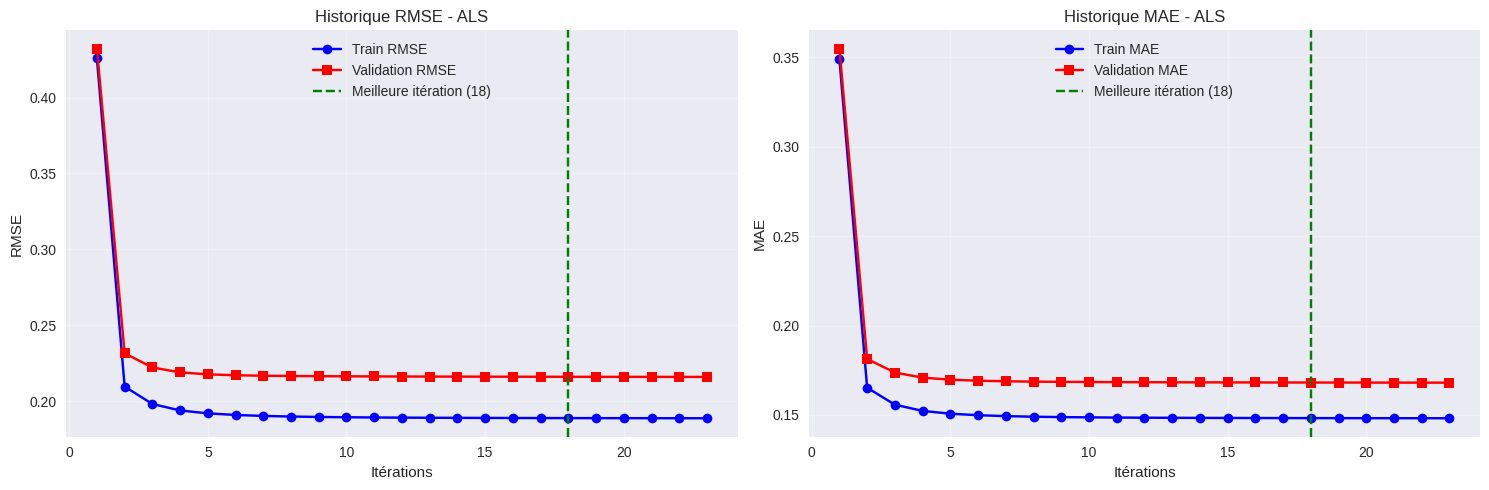

📊 ÉVALUATION SUR LE TEST SET:
   RMSE: 0.2160
   MAE:  0.1683

📈 COMPARAISON DES MÉTRIQUES:
   Modèle          RMSE       MAE       
   --------------- ---------- ----------
   ALS             0.2160     0.1683    


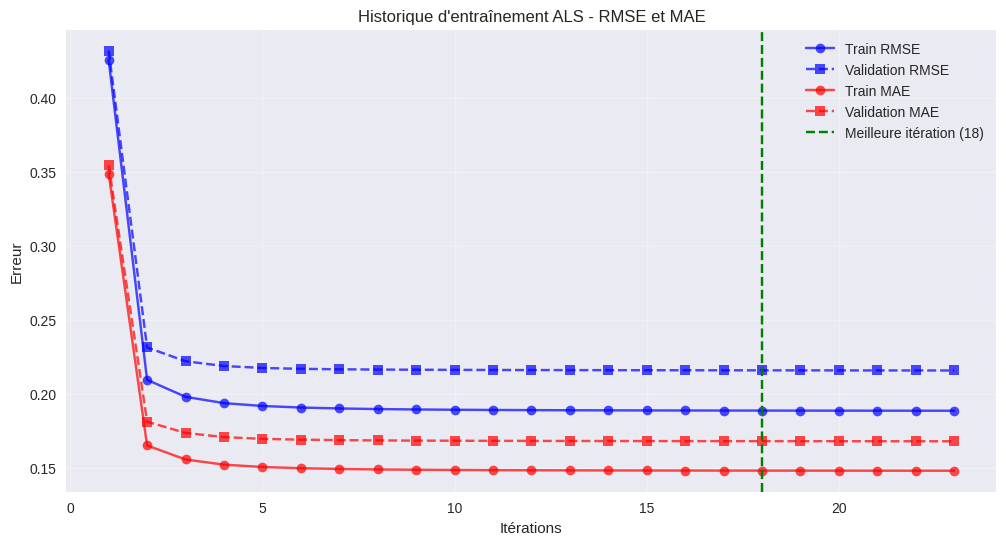

In [73]:
print(f"\n📊 RÉSULTATS FINAUX - Modèle Manuel avec Early Stopping:")
print(f"   ✅ Meilleure itération: {manual_model.best_iteration + 1}/{BEST_ITERATIONS}")
print(f"   ✅ RMSE Validation: {manual_model.best_rmse:.4f}")
print(f"   ✅ RMSE Test final: {manual_test_rmse:.4f}")
print(f"   ✅ MAE Test final: {manual_test_mae:.4f}")
print(f"   ✅ Gain de temps: {((BEST_ITERATIONS - (manual_model.best_iteration + 1)) / BEST_ITERATIONS * 100):.1f}%")

# Affichage de l'historique d'entraînement
print(f"\n📈 HISTORIQUE D'ENTRAÎNEMENT:")
for i, (train_rmse, val_rmse) in enumerate(zip(manual_model.train_rmse, manual_model.val_rmse)):
    marker = " 🌟" if i == manual_model.best_iteration else ""
    print(f"   Itération {i+1:2d}: Train RMSE = {train_rmse:.4f}, Val RMSE = {val_rmse:.4f}{marker}")

# Visualisation de l'historique
manual_model.plot_training_history()

# Évaluation sur le test set avec les deux métriques
test_rmse, test_mae = manual_model.evaluate_test_set(test_matrix)
print(f"\n📈 COMPARAISON DES MÉTRIQUES:")
print(f"   {'Modèle':<15} {'RMSE':<10} {'MAE':<10}")
print(f"   {'-'*15} {'-'*10} {'-'*10}")
print(f"   {'ALS':<15} {test_rmse:<10.4f} {test_mae:<10.4f}")

# Affichage de l'historique combiné
manual_model.plot_combined_training_history()

In [74]:
# ============================================================================
# 
# ============================================================================

def calculate_ndcg_fixed(recommended_items, test_matrix, user_id, k, threshold=0.7):
    """Calcule le NDCG pour données normalisées (0-1)"""
    dcg = 0.0
    relevance_scores = []
    
    # Récupérer TOUTES les notes de l'utilisateur dans le test set
    user_test_data = test_matrix[user_id].tocoo()
    user_ratings_dict = {item_id: rating for item_id, rating in zip(user_test_data.col, user_test_data.data)}
    
    for i, item_id in enumerate(recommended_items[:k]):
        # Utiliser le dictionnaire pour récupérer la vraie note
        true_rating = user_ratings_dict.get(item_id, 0)
        
        # Convertir en score de pertinence (0 si < threshold, note sinon)
        # Ajusté pour l'échelle 0-1 (0.7 ≈ 3.5/5)
        relevance = true_rating if true_rating >= threshold else 0
        relevance_scores.append(relevance)
        
        if relevance > 0:
            dcg += relevance / math.log2(i + 2)
    
    # IDCG : trier les notes par ordre décroissant
    ideal_relevance = sorted(relevance_scores, reverse=True)
    idcg = sum(rel / math.log2(i + 2) for i, rel in enumerate(ideal_relevance) if rel > 0)
    
    return dcg / idcg if idcg > 0 else 0.0


def calculate_metrics_fixed(model, train_matrix, test_matrix, k=30, threshold=0.7):
    """Version corrigée pour données normalisées (0-1)"""
    n_users, n_items = train_matrix.shape
    precision_list, recall_list, f1_list, ndcg_list = [], [], [], []
    all_recommended_items = set()
    
    for user_id in range(n_users):
        user_test_ratings = test_matrix[user_id].tocoo()
        relevant_items = set()
        
        # Identifier les items pertinents (note >= threshold)
        for idx in range(len(user_test_ratings.data)):
            if user_test_ratings.data[idx] >= threshold:
                relevant_items.add(user_test_ratings.col[idx])
        
        if not relevant_items:
            continue
        
        try:
            # Obtenir les recommandations
            recs = model.recommend_for_user(user_id, n_recommendations=k, min_ratings=5)  # Réduit min_ratings
            recommended_items = [item_id for item_id, _ in recs]
            
            all_recommended_items.update(recommended_items)
            
            # Calcul des métriques de base
            hits = len(set(recommended_items) & relevant_items)
            precision = hits / k if k > 0 else 0
            recall = hits / len(relevant_items) if len(relevant_items) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
            
            # NDCG
            ndcg = calculate_ndcg_fixed(recommended_items, test_matrix, user_id, k, threshold)
            ndcg_list.append(ndcg)
            
        except Exception as e:
            # Debug des erreurs
            # print(f"Erreur pour l'utilisateur {user_id}: {e}")
            continue
    
    # Statistiques finales
    users_evaluated = len(precision_list)
    
    return {
        "Precision@k": np.mean(precision_list) if precision_list else 0,
        "Recall@k": np.mean(recall_list) if recall_list else 0,
        "F1@k": np.mean(f1_list) if f1_list else 0,
        "NDCG@k": np.mean(ndcg_list) if ndcg_list else 0,
        "Coverage@k": len(all_recommended_items) / n_items if n_items > 0 else 0,
        "Users_evaluated": users_evaluated,
        "Total_users": n_users
    }


# ============================================================================
# FONCTION POUR DÉNORMALISER LES PRÉDICTIONS
# ============================================================================
def denormalize_predictions(model, recommendations, scale):
    min_rating, max_rating = scale
    denormalized_recs = []
    
    for item_id, pred, actual_rating_normalized in recommendations:
        # Dénormalisation de la prédiction
        denorm_pred = pred * (max_rating - min_rating) + min_rating
        
        if actual_rating_normalized > 0:
            # C'est une vraie note → dénormaliser
            denorm_actual = actual_rating_normalized * (max_rating - min_rating) + min_rating
        else:
            # C'est une absence de note → mettre None
            denorm_actual = None
        
        denormalized_recs.append((item_id, denorm_pred, denorm_actual))
    
    return denormalized_recs

def denormalize_predictions_advanced(recommendations, scale, epsilon=1e-6):
    """
    Version avancée avec détection plus fine des absences de notes
    """
    min_rating, max_rating = scale
    denormalized_recs = []
    
    # Calcul du seuil : les notes très proches de 0 sont probablement des absences
    threshold = 0.1 * (max_rating - min_rating) / (max_rating - min_rating)  # 10% de l'échelle normalisée
    
    for item_id, pred, actual_rating_normalized in recommendations:
        # Dénormalisation de la prédiction
        denorm_pred = pred * (max_rating - min_rating) + min_rating
        
        # Détection intelligente des absences
        if actual_rating_normalized is None or actual_rating_normalized <= threshold:
            denorm_actual = None  # Absence de note
        else:
            denorm_actual = actual_rating_normalized * (max_rating - min_rating) + min_rating
        
        denormalized_recs.append((item_id, denorm_pred, denorm_actual))
    
    return denormalized_recs

In [75]:
# ============================================================================
# FONCTION D'ÉVALUATION COMPLÈTE
# ============================================================================

def evaluate_model_comprehensive(model, train_matrix, test_matrix, scale, k_values=[5, 10, 20, 30]):
    """
    Évaluation complète avec différentes valeurs de k
    """
    results = {}
    
    for k in k_values:
        print(f"\n📊 Évaluation avec k={k}...")
        
        # Seuil adapté pour données normalisées (0.7 ≈ 3.5/5)
        threshold = 0.7
        
        metrics = calculate_metrics_fixed(
            model, train_matrix, test_matrix, 
            k=k, threshold=threshold
        )
        
        results[f"k={k}"] = metrics
        
        print(f"   Precision@{k}: {metrics['Precision@k']:.4f}")
        print(f"   Recall@{k}: {metrics['Recall@k']:.4f}")
        print(f"   F1@{k}: {metrics['F1@k']:.4f}")
        print(f"   NDCG@{k}: {metrics['NDCG@k']:.4f}")
        print(f"   Coverage@{k}: {metrics['Coverage@k']:.4f}")
        print(f"   Utilisateurs évalués: {metrics['Users_evaluated']}/{metrics['Total_users']}")
    
    return results


# 1. Évaluation du modèle
print("🧪 ÉVALUATION DU MODÈLE AVEC DONNÉES NORMALISÉES")
results = evaluate_model_comprehensive(manual_model, train_data_split, test_matrix, scale)

🧪 ÉVALUATION DU MODÈLE AVEC DONNÉES NORMALISÉES

📊 Évaluation avec k=5...
   Precision@5: 0.1694
   Recall@5: 0.0442
   F1@5: 0.0597
   NDCG@5: 0.3527
   Coverage@5: 0.1751
   Utilisateurs évalués: 6026/6040

📊 Évaluation avec k=10...
   Precision@10: 0.1417
   Recall@10: 0.0749
   F1@10: 0.0794
   NDCG@10: 0.3870
   Coverage@10: 0.2393
   Utilisateurs évalués: 6026/6040

📊 Évaluation avec k=20...
   Precision@20: 0.1153
   Recall@20: 0.1183
   F1@20: 0.0937
   NDCG@20: 0.4049
   Coverage@20: 0.3152
   Utilisateurs évalués: 6026/6040

📊 Évaluation avec k=30...
   Precision@30: 0.1015
   Recall@30: 0.1550
   F1@30: 0.0992
   NDCG@30: 0.4128
   Coverage@30: 0.3586
   Utilisateurs évalués: 6026/6040


In [76]:
# 2. Exemple de recommandations dénormalisées
print("\n🎯 EXEMPLE DE RECOMMANDATIONS DÉNORMALISÉES")
user_id = 270

# Obtenir les recommandations normalisées
recs_normalized = manual_model.recommend_for_user(
    user_id, 
    n_recommendations=10, 
    min_ratings=5, 
    include_actual=True
)

# Dénormaliser avec gestion des absences
recs_denormalized = denormalize_predictions_advanced(recs_normalized, scale)

print(f"Recommandations pour l'utilisateur {user_id}:")
print("=" * 70)

for i, (item_id, pred_rating, actual_rating) in enumerate(recs_denormalized):
    if actual_rating is not None:
        # Cas où l'utilisateur a vraiment noté le film
        error = abs(pred_rating - actual_rating)
        print(f"  {i+1:2d}. Item {item_id:4d}")
        print(f"       ✅ Note réelle: {actual_rating:5.2f}")
        print(f"       🎯 Note prédite: {pred_rating:5.2f}")
        print(f"       📊 Erreur: {error:5.2f}")
    else:
        # Cas où l'utilisateur n'a pas noté le film (nouvelle recommandation)
        print(f"  {i+1:2d}. Item {item_id:4d}")
        print(f"       🎯 Note prédite: {pred_rating:5.2f}")
        print(f"       🔍 Situation: Film non noté par l'utilisateur")
    print()


🎯 EXEMPLE DE RECOMMANDATIONS DÉNORMALISÉES
Recommandations pour l'utilisateur 270:
   1. Item   64
       ✅ Note réelle:  5.00
       🎯 Note prédite:  5.00
       📊 Erreur:  0.00

   2. Item  167
       ✅ Note réelle:  4.00
       🎯 Note prédite:  5.00
       📊 Erreur:  1.00

   3. Item  259
       🎯 Note prédite:  5.00
       🔍 Situation: Film non noté par l'utilisateur

   4. Item  505
       ✅ Note réelle:  5.00
       🎯 Note prédite:  5.00
       📊 Erreur:  0.00

   5. Item   52
       🎯 Note prédite:  5.00
       🔍 Situation: Film non noté par l'utilisateur

   6. Item   29
       ✅ Note réelle:  5.00
       🎯 Note prédite:  5.00
       📊 Erreur:  0.00

   7. Item  506
       🎯 Note prédite:  5.00
       🔍 Situation: Film non noté par l'utilisateur

   8. Item  500
       🎯 Note prédite:  5.00
       🔍 Situation: Film non noté par l'utilisateur

   9. Item 1467
       🎯 Note prédite:  4.99
       🔍 Situation: Film non noté par l'utilisateur

  10. Item  377
       🎯 Note prédite:

In [77]:
# 3. Vérification des statistiques des données
print(f"\n📈 STATISTIQUES DES DONNÉES:")
print(f"   Échelle de dénormalisation: {scale}")
print(f"   Données train - Min: {train_data_split.data.min():.3f}, Max: {train_data_split.data.max():.3f}")
print(f"   Données test - Min: {test_matrix.data.min():.3f}, Max: {test_matrix.data.max():.3f}")


📈 STATISTIQUES DES DONNÉES:
   Échelle de dénormalisation: (1, 5)
   Données train - Min: 0.000, Max: 1.000
   Données test - Min: 0.000, Max: 1.000


In [78]:
# # Exemple de recommandations dénormalisées
# user_id = 326  # Utilisateur choisi

# # Obtenir les recommandations normalisées
# recs_normalized = manual_model.recommend_for_user(user_id, n_recommendations=10, min_ratings=5, include_actual=True)

# # Dénormaliser
# recs_denormalized = denormalize_predictions(manual_model, recs_normalized, (0, 5))

# print(f"Recommandations pour l'utilisateur {user_id}:")
# for i, (item_id, pred_rating, actual_rating) in enumerate(recs_denormalized):
#     print(f"  {i+1}. Item {item_id} → Note réelle: {actual_rating} → Note prédite: {pred_rating:.2f}")

# **SVD**


In [79]:
# ============================================================================
# SVD AVEC LA BIBLIOTHÈQUE SURPRISE POUR COMPARAISON
# ============================================================================

!pip install scikit-surprise

import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt

print("=" * 70)
print("🧪 SVD AVEC BIBLIOTHÈQUE SURPRISE")
print("=" * 70)

# ============================================================================
# PRÉPARATION DES DONNÉES POUR SURPRISE
# ============================================================================

# Convertir nos matrices sparse en DataFrame pour surprise
def sparse_to_dataframe(matrix, user_map, item_map):
    """Convertit une matrice sparse en DataFrame pour surprise"""
    coo = matrix.tocoo()
    
    # Inverser les mappings
    user_map_inv = {v: k for k, v in user_map.items()}
    item_map_inv = {v: k for k, v in item_map.items()}
    
    # Créer le DataFrame
    data = []
    for user_idx, item_idx, rating in zip(coo.row, coo.col, coo.data):
        original_user = user_map_inv[user_idx]
        original_item = item_map_inv[item_idx]
        data.append([original_user, original_item, rating])
    
    return pd.DataFrame(data, columns=['UserID', 'MovieID', 'Rating'])

# Conversion des données
print("📊 Conversion des données pour Surprise...")
train_df = sparse_to_dataframe(train_data_split, user_map, item_map)
test_df = sparse_to_dataframe(test_matrix, user_map, item_map)

print(f"   Train: {len(train_df)} ratings")
print(f"   Test: {len(test_df)} ratings")

# Configuration du reader pour Surprise
reader = Reader(rating_scale=(0, 1))  # Nos données sont normalisées entre 0 et 1

# Chargement des données
train_data = Dataset.load_from_df(train_df[['UserID', 'MovieID', 'Rating']], reader)
test_data = Dataset.load_from_df(test_df[['UserID', 'MovieID', 'Rating']], reader)

# Construction des trainset et testset
trainset = train_data.build_full_trainset()
testset = test_data.build_full_trainset().build_testset()

# ============================================================================
# ENTRAÎNEMENT DU MODÈLE SVD
# ============================================================================

print("\n🚀 Entraînement du modèle SVD avec Surprise...")

# Paramètres optimisés pour SVD
svd_params = {
    'n_factors': 10,           # Facteurs latents
    'n_epochs': 30,             # Itérations
    'lr_all': 0.005,            # Taux d'apprentissage
    'reg_all': 1.1,            # Régularisation
    'random_state': 42
}

# Initialisation et entraînement
svd_model = SVD(**svd_params)
svd_model.fit(trainset)

print("✅ SVD entraîné avec succès!")

🧪 SVD AVEC BIBLIOTHÈQUE SURPRISE
📊 Conversion des données pour Surprise...
   Train: 677129 ratings
   Test: 247844 ratings

🚀 Entraînement du modèle SVD avec Surprise...
✅ SVD entraîné avec succès!


In [80]:
# ============================================================================
# ÉVALUATION DU MODÈLE SVD
# ============================================================================

# Prédictions sur le test set
test_predictions = svd_model.test(testset)

# Calcul des métriques
svd_rmse = accuracy.rmse(test_predictions, verbose=False)
svd_mae = accuracy.mae(test_predictions, verbose=False)

print(f"\n📊 PERFORMANCE SVD:")
print(f"   RMSE: {svd_rmse:.4f}")
print(f"   MAE:  {svd_mae:.4f}")

# ============================================================================
# COMPARAISON AVEC ALS
# ============================================================================

print(f"\n📈 COMPARAISON ALS vs SVD:")
print(f"   {'Modèle':<15} {'RMSE':<10} {'MAE':<10} {'Facteurs':<10}")
print(f"   {'-'*15} {'-'*10} {'-'*10} {'-'*10}")
print(f"   {'ALS':<15} {manual_test_rmse:<10.4f} {manual_test_mae:<10.4f} {BEST_N_FACTORS:<10}")
print(f"   {'SVD':<15} {svd_rmse:<10.4f} {svd_mae:<10.4f} {svd_params['n_factors']:<10}")


📊 PERFORMANCE SVD:
   RMSE: 0.2417
   MAE:  0.1965

📈 COMPARAISON ALS vs SVD:
   Modèle          RMSE       MAE        Facteurs  
   --------------- ---------- ---------- ----------
   ALS             0.2160     0.1683     10        
   SVD             0.2417     0.1965     10        


In [81]:
# ============================================================================
# RECOMMANDATIONS AVEC SVD
# ============================================================================

def svd_recommend_for_user(model, user_id, n_recommendations=10, min_ratings=5):
    """Génère des recommandations avec le modèle SVD"""
    # Items déjà notés par l'utilisateur
    user_ratings = train_df[train_df['UserID'] == user_id]['MovieID'].values
    user_rated_items = set(user_ratings)
    
    # Tous les items disponibles
    all_items = train_df['MovieID'].unique()
    
    # Popularité des items
    item_popularity = train_df['MovieID'].value_counts().to_dict()
    
    # Prédire pour tous les items non notés
    predictions = []
    for item_id in all_items:
        if item_id not in user_rated_items and item_popularity.get(item_id, 0) >= min_ratings:
            pred_rating = model.predict(user_id, item_id).est
            predictions.append((item_id, pred_rating, item_popularity.get(item_id, 0)))
    
    # Trier par note prédite décroissante
    predictions.sort(key=lambda x: (-x[1], -x[2]))
    
    return [(item_id, pred_rating) for item_id, pred_rating, _ in predictions[:n_recommendations]]

# Exemple de recommandations
print(f"\n🎯 RECOMMANDATIONS SVD (Utilisateur 34):")
user_test_id = 34

svd_recs = svd_recommend_for_user(svd_model, user_test_id, n_recommendations=5, min_ratings=5)

for i, (item_id, pred_rating) in enumerate(svd_recs):
    print(f"   {i+1}. Item {item_id} → Note prédite: {pred_rating:.4f}")

# ============================================================================
# ÉVALUATION AVEC NOS MÉTRIQUES PERSONNALISÉES
# ============================================================================

# Adaptateur pour utiliser SVD avec nos fonctions d'évaluation
class SVDWrapper:
    """Wrapper pour utiliser SVD de surprise avec nos fonctions d'évaluation"""
    def __init__(self, svd_model, user_map, item_map):
        self.svd_model = svd_model
        self.user_map = user_map
        self.item_map = item_map
        
    def recommend_for_user(self, user_idx, n_recommendations=10, min_ratings=5, include_actual=False):
        # Convertir l'index interne en UserID original
        user_map_inv = {v: k for k, v in self.user_map.items()}
        user_id = user_map_inv[user_idx]
        
        recommendations = svd_recommend_for_user(
            self.svd_model, user_id, n_recommendations, min_ratings
        )
        
        if include_actual:
            # Ajouter les notes réelles si demandé
            enhanced_recs = []
            for item_id, pred in recommendations:
                # Convertir l'item_id original en index interne
                item_idx = self.item_map.get(item_id, -1)
                if item_idx != -1:
                    actual_rating = test_matrix[user_idx, item_idx]
                    enhanced_recs.append((item_id, pred, actual_rating))
                else:
                    enhanced_recs.append((item_id, pred, 0))
            return enhanced_recs
        else:
            return recommendations

# Création du wrapper
svd_wrapper = SVDWrapper(svd_model, user_map, item_map)

# Évaluation avec nos métriques
print(f"\n📊 ÉVALUATION AVEC NOS MÉTRIQUES:")
svd_metrics = calculate_metrics_fixed(svd_wrapper, train_data_split, test_matrix, k=10, threshold=0.7)
als_metrics = calculate_metrics_fixed(manual_model, train_data_split, test_matrix, k=10, threshold=0.7)

print(f"\n{'Métrique':<15} {'ALS':<10} {'SVD':<10} {'Diff':<10}")
print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*10}")
for metric in ['Precision@k', 'Recall@k', 'F1@k', 'NDCG@k', 'Coverage@k']:
    als_val = als_metrics.get(metric, 0)
    svd_val = svd_metrics.get(metric, 0)
    diff = svd_val - als_val
    diff_str = f"+{diff:.4f}" if diff > 0 else f"{diff:.4f}"
    print(f"{metric:<15} {als_val:<10.4f} {svd_val:<10.4f} {diff_str:<10}")


🎯 RECOMMANDATIONS SVD (Utilisateur 34):
   1. Item 2905 → Note prédite: 0.8055
   2. Item 3338 → Note prédite: 0.7981
   3. Item 1117 → Note prédite: 0.7973
   4. Item 2019 → Note prédite: 0.7865
   5. Item 527 → Note prédite: 0.7861

📊 ÉVALUATION AVEC NOS MÉTRIQUES:

Métrique        ALS        SVD        Diff      
--------------- ---------- ---------- ----------
Precision@k     0.1417     0.0070     -0.1347   
Recall@k        0.0749     0.0023     -0.0726   
F1@k            0.0794     0.0030     -0.0764   
NDCG@k          0.3870     0.0215     -0.3655   
Coverage@k      0.2393     0.0070     -0.2323   


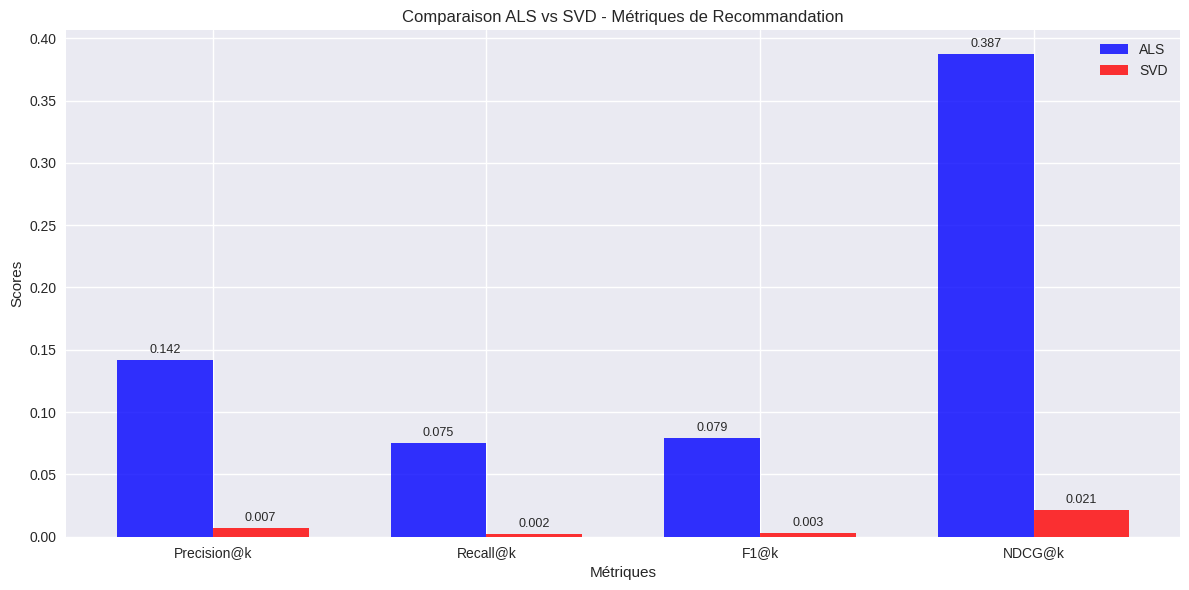

In [82]:
# ============================================================================
# VISUALISATION DES PERFORMANCES
# ============================================================================

# Graphique de comparaison
metrics_names = ['Precision@k', 'Recall@k', 'F1@k', 'NDCG@k']
als_scores = [als_metrics[m] for m in metrics_names]
svd_scores = [svd_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, als_scores, width, label='ALS', alpha=0.8, color='blue')
bars2 = ax.bar(x + width/2, svd_scores, width, label='SVD', alpha=0.8, color='red')

ax.set_xlabel('Métriques')
ax.set_ylabel('Scores')
ax.set_title('Comparaison ALS vs SVD - Métriques de Recommandation')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()

# Ajouter les valeurs sur les barres
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [83]:
# ============================================================================
# HYPERPARAMÈTRES ET OPTIMISATION
# ============================================================================

print(f"\n⚙️  HYPERPARAMÈTRES UTILISÉS:")
print(f"   ALS:")
print(f"     - n_factors: {BEST_N_FACTORS}")
print(f"     - lambda_reg: {BEST_LAMBDA}")
print(f"     - n_iterations: {BEST_ITERATIONS}")
print(f"   SVD:")
print(f"     - n_factors: {svd_params['n_factors']}")
print(f"     - n_epochs: {svd_params['n_epochs']}")
print(f"     - lr_all: {svd_params['lr_all']}")
print(f"     - reg_all: {svd_params['reg_all']}")


⚙️  HYPERPARAMÈTRES UTILISÉS:
   ALS:
     - n_factors: 10
     - lambda_reg: 1.1
     - n_iterations: 30
   SVD:
     - n_factors: 10
     - n_epochs: 30
     - lr_all: 0.005
     - reg_all: 1.1


In [84]:
# ============================================================================
# RECOMMANDATIONS DÉNORMALISÉES COMPARÉES
# ============================================================================

def denormalize_svd_predictions(recommendations, scale):
    """Dénormalise les prédictions SVD"""
    min_rating, max_rating = scale
    denormalized_recs = []
    
    for item_id, pred, actual_rating in recommendations:
        denorm_pred = pred * (max_rating - min_rating) + min_rating
        denorm_actual = actual_rating * (max_rating - min_rating) + min_rating if actual_rating > 0 else None
        denormalized_recs.append((item_id, denorm_pred, denorm_actual))
    
    return denormalized_recs
    
print(f"\n🎯 RECOMMANDATIONS DÉNORMALISÉES COMPARÉES:")
user_test_id = 270

# ALS
als_recs = manual_model.recommend_for_user(user_test_id, n_recommendations=8, min_ratings=5, include_actual=True)
als_recs_denorm = denormalize_predictions(manual_model, als_recs, scale)

# SVD
svd_recs = svd_wrapper.recommend_for_user(user_test_id, n_recommendations=8, min_ratings=5, include_actual=True)
svd_recs_denorm = denormalize_svd_predictions(svd_recs, scale)

print(f"\n🔹 ALS:")
for i, (item_id, pred, actual) in enumerate(als_recs_denorm):
    status = "✅" if actual is not None else "🆕"
    actual_str = f"{actual:.2f}" if actual is not None else "Non noté"
    print(f"   {i+1}. Item {item_id:4d} {status} Prédit: {pred:.2f} | Réel: {actual_str}")

print(f"\n🔹 SVD:")
for i, (item_id, pred, actual) in enumerate(svd_recs_denorm):
    status = "✅" if actual is not None else "🆕"
    actual_str = f"{actual:.2f}" if actual is not None else "Non noté"
    print(f"   {i+1}. Item {item_id:4d} {status} Prédit: {pred:.2f} | Réel: {actual_str}")

print(f"\n✅ COMPARAISON TERMINÉE!")


🎯 RECOMMANDATIONS DÉNORMALISÉES COMPARÉES:

🔹 ALS:
   1. Item   64 ✅ Prédit: 5.00 | Réel: 5.00
   2. Item  167 ✅ Prédit: 5.00 | Réel: 4.00
   3. Item  259 🆕 Prédit: 5.00 | Réel: Non noté
   4. Item  505 ✅ Prédit: 5.00 | Réel: 5.00
   5. Item   52 🆕 Prédit: 5.00 | Réel: Non noté
   6. Item   29 ✅ Prédit: 5.00 | Réel: 5.00
   7. Item  506 🆕 Prédit: 5.00 | Réel: Non noté
   8. Item  500 🆕 Prédit: 5.00 | Réel: Non noté

🔹 SVD:
   1. Item 2905 🆕 Prédit: 4.28 | Réel: Non noté
   2. Item 3338 🆕 Prédit: 4.25 | Réel: Non noté
   3. Item 1117 🆕 Prédit: 4.25 | Réel: Non noté
   4. Item  318 ✅ Prédit: 4.22 | Réel: 4.00
   5. Item 2019 ✅ Prédit: 4.21 | Réel: 4.00
   6. Item  527 🆕 Prédit: 4.20 | Réel: Non noté
   7. Item  745 ✅ Prédit: 4.20 | Réel: 5.00
   8. Item  858 🆕 Prédit: 4.18 | Réel: Non noté

✅ COMPARAISON TERMINÉE!
